# Packages

In [479]:
%%capture
!pip install wget
!pip install wandb
!pip install plot_keras_history
!jupyter nbextension enable --py widgetsnbextension

In [480]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [481]:
import pandas as pd
import cv2
import wget
import shutil
from tensorflow.keras.applications import VGG16
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import re
import json
import numpy as np
from plot_keras_history import show_history, plot_history

from textwrap import wrap
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import random
from wandb.keras import WandbCallback
import wandb
import time
from keras import backend as K
from os.path import exists
from tensorflow.keras.utils import to_categorical

In [482]:
DATA_DIR = "/content/" # change to /content/ if running on GG COLAB
VISUALIZATION = False  
BATCH_SIZE = 4                    
LEARNING_RATE = 0.0001         
NUM_EPOCHS = 100
IMAGE_SIZE = 64
LOSS = ""


In [483]:
if not exists(f'{DATA_DIR}train.csv'):
    os.system(f'wget -P {DATA_DIR} https://github.com/Toloka/WSDMCup2023/raw/main/train.csv')
if not exists(f'saved_images'):
    os.system('mkdir saved_images')

In [484]:
num_GPU = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(num_GPU))

Num GPUs Available:  1


In [485]:
TEST_TRAINING  = True

# Data Loader

In [486]:
train = pd.read_csv(DATA_DIR  + 'train.csv')
TRAIN_IMGS_DIR = DATA_DIR + "train_imgs/"
if TEST_TRAINING:
    train = train[:5000]

In [487]:
# Download data
try:
    os.mkdir(TRAIN_IMGS_DIR)
    img_paths = Parallel(
    n_jobs=100)(delayed(wget.download)(img_url, out= TRAIN_IMGS_DIR) for img_url in tqdm(train.image)
    )
except:
    print("the training set has been downloaded")

the training set has been downloaded


In [488]:
#Get the image path from URL
train.image  = train.image.apply(lambda x: str(x.split("/")[-1]))
train.image  = train.image.apply(lambda x: TRAIN_IMGS_DIR + str(x))

In [489]:
#Spit the original training set into 2 dataframes
train_sample = int(len(train)*0.8)
df_train = train[:int(len(train)*0.8)]
df_val = train[int(len(train)*0.8):]

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)

if TEST_TRAINING:
    df_train = df_train[:1000*BATCH_SIZE]
    df_val =  df_val

## Image Processing

In [490]:
%pylab inline
from concurrent.futures import process


def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    cols, rows,*_ = x.shape
    Y = np.zeros((cols, rows))
    bb = bb.astype(np.int64)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    rows , cols = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int64)

def xyxy2xywh(box): #Convert box format [xmin ymin xmax ymax] --> [x center, y center, width, height] and normalize the box
    xmin, ymin, xmax, ymax = box
    w = xmax - xmin         # Width of the box
    h = ymax - ymin         # Height of the box
    x_center = (xmin + (w/2))/IMAGE_SIZE 
    y_center = (ymin + (h/2))/IMAGE_SIZE 
    new_w = w/ IMAGE_SIZE 
    new_h = h/IMAGE_SIZE
    return np.array([x_center,y_center, new_w, new_h], dtype=np.float32)
    
def xywh2xyxy(box): #Convert box format [x center, y center, width, height]  --> [xmin ymin xmax ymax] and normalize the box
    x_center,y_center, new_w, new_h = box*IMAGE_SIZE
    xmin = x_center - (new_w/2)
    ymin = y_center - (new_h/2)
    xmax = x_center + (new_w/2)
    ymax = y_center + (new_h/2)
    return np.array([xmin, ymin, xmax, ymax], dtype=np.int64)

def resize_image_bb(img_path, bb, sz = IMAGE_SIZE):
    """Resize an image and its bounding box and write image to new path"""
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    mask = create_mask(bb, img)
    img_resized = cv2.resize(img, (sz, sz))
    mask_resized = cv2.resize(mask, (sz, sz))
    bb_resized = mask_to_bb(mask_resized)
    x_center,y_center, new_w, new_h = xyxy2xywh(bb_resized)
    processed_box = np.array([x_center,y_center, new_w, new_h], dtype=np.float32)
    return np.array(img_resized, dtype = np.float32), bb_resized, processed_box


Populating the interactive namespace from numpy and matplotlib


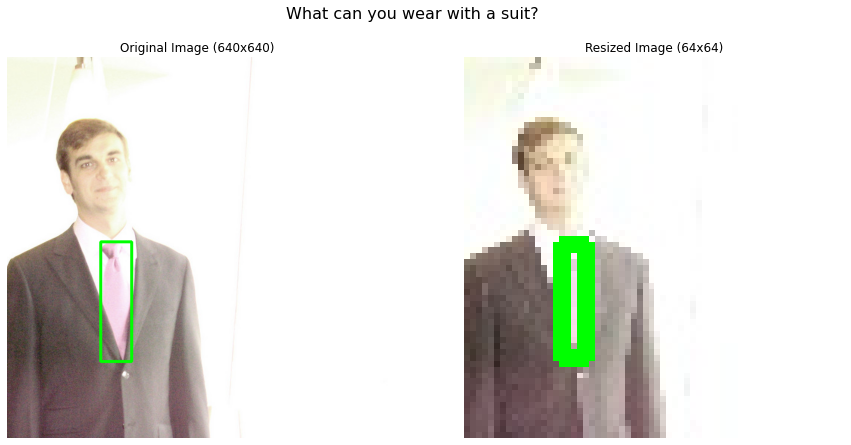

--------------------------------------------------------------------------------------------------------------


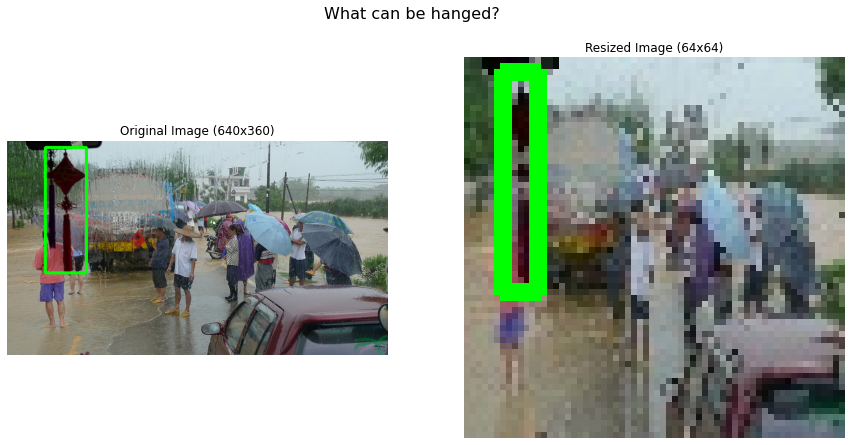

--------------------------------------------------------------------------------------------------------------


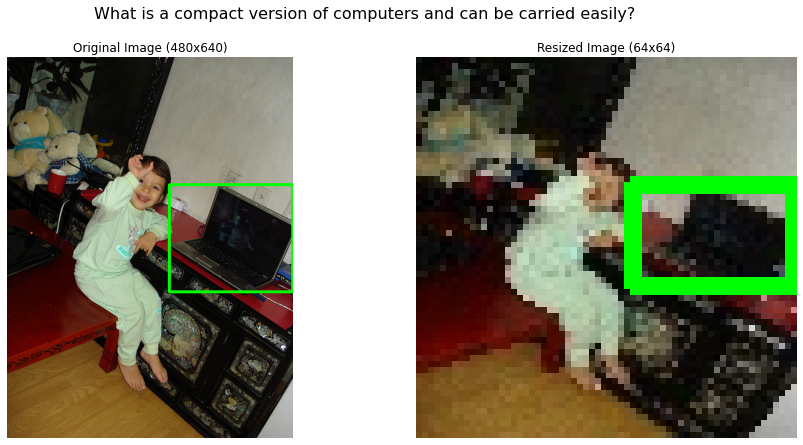

--------------------------------------------------------------------------------------------------------------


In [491]:
idxes = numpy.random.randint(1, len(df_train), 3)
plt.show()
for idx in idxes:
    img_path, w, h, l, t, r, b, question = df_train.iloc[idx]
    plt.figure(figsize = (15, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image ({w}x{h})")
    plt.axis('off')
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    result = img.copy()
    cv2.rectangle(result, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 3)
    plt.imshow(result)
    
    resized_img, resized_box, processed_box = resize_image_bb(img_path, np.array([l, t, r, b]), IMAGE_SIZE)
    cv2.imwrite(f'./saved_images/img.jpg', resized_img)
    resized_img = cv2.cvtColor(cv2.imread(f'./saved_images/img.jpg'), cv2.COLOR_BGR2RGB)
    result = resized_img.copy()
    cv2.rectangle(result, (int(resized_box[0]), int(resized_box[1])), (int(resized_box[2]), int(resized_box[3])), (0, 255, 0), 2)
    plt.subplot(1, 2, 2)
    plt.title(f"Resized Image ({IMAGE_SIZE}x{IMAGE_SIZE})")
    plt.axis('off')
    plt.xlabel(IMAGE_SIZE)
    plt.ylabel(IMAGE_SIZE)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.suptitle(question, fontsize=16)
    #plt.tight_layout()
    #plt.subplots_adjust(top=1)
    plt.show()
    print("-"*110)


## Box Processing

We convert 2D boxed to 1D box

In [492]:
img_path, w, h, l, t, r, b, question = df_train.iloc[3]
resized_img, resized_box, processed_box = resize_image_bb(img_path, np.array([l, t, r, b]), IMAGE_SIZE)

In [493]:
print(f"The Image size : {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Assuming that A is the top-left corner of the Image, A : ({resized_box[0]},{resized_box[1]})")
print(f"Assuming that B is the Bottom-right corner of the Image, B : ({resized_box[2]},{resized_box[3]})")

The Image size : 64x64
Assuming that A is the top-left corner of the Image, A : (5,50)
Assuming that B is the Bottom-right corner of the Image, B : (63,58)


We use the following formula to turn A and B to 1D point:

$x_{1D} =  x_{2D} * \text{IMAGE_SIZE} + y_{2D}$

In [494]:
print(f"the dimension of 1 output (IMAGE_SIZExIMAGE_SIZE): {IMAGE_SIZE*IMAGE_SIZE}")
print(f"A in 1D: {resized_box[0]*IMAGE_SIZE+resized_box[1]}")
print(f"B in 1D: {resized_box[2]*IMAGE_SIZE + resized_box[3]}")

the dimension of 1 output (IMAGE_SIZExIMAGE_SIZE): 4096
A in 1D: 370
B in 1D: 4090


In [495]:
def box_processing(boxes, img_size = IMAGE_SIZE):
    lt = boxes[:,0]*img_size + boxes[:,1]
    rb = boxes[:,2]*img_size + boxes[:,3]
    return lt, rb

## Question Processing

In [496]:
class Text_Dict:

    """Aim to convert index to word or word to index"""

    def __init__(self, vocab):
        
        self.word_list = vocab
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(f'word {w} not in dictionary (while dictionary does not contain <unk>)')

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

## Data Pipeline Loaders

In [497]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, question_vocab, batch_size=32):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.question_vocab = question_vocab
        self.question_dict = Text_Dict(self.question_vocab)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))


    def make_vocab_questions(self, questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list


    def tokenize(self, sentence):

        """Split string lines into lists"""
        
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
        tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
        return tokens

    def question_processing(self, question):
        question_token = self.tokenize(question)
        question_2_idx = [self.question_dict.word2idx(w) for w in question_token ]
        return  question_2_idx
    


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        images, questions, left_top,  right_bottom= self.__data_generation(batch_data)
        
        return [{
            'input_image': np.array(images, dtype =np.float32),
            'input_question': np.array(questions, dtype =int)
        },{
            'output_1': to_categorical(left_top, num_classes = IMAGE_SIZE**2),
            'output_2':to_categorical(right_bottom, num_classes = IMAGE_SIZE**2)
        }]

    def __data_generation(self, batch_data):
        images = []
        questions = []
        question_len = []
        boxes = []
        for image_path, width, hieght, left, top, right, bottom, question in batch_data:
            box = np.array([left, top, right, bottom],dtype = np.float32)
            resized_image, resized_box, processed_box = resize_image_bb(image_path, box, IMAGE_SIZE)
            question = self.question_processing(question)
            question_len.append(len(question))
            questions.append(question)
            boxes.append(resized_box)
            images.append(resized_image/225)
        left_top, right_bottom = box_processing(np.array(boxes))
        questions = pad_sequences(questions, maxlen = max(question_len), dtype='float32', value=0, padding='pre')
        return images, questions, left_top, right_bottom


In [498]:
def make_vocab_questions(questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list

In [499]:
question_vocab = make_vocab_questions(train["question"])

- Creating a vocab list for questions
    + The size of Question vocabbulary 2894.
    + Maximum length of question: 29


In [500]:
print("print 1 batch")
print("-"*50)
train_generator = DataGenerator(df_train,question_vocab, BATCH_SIZE)
batch = train_generator[0]
print(f'image_shape:\n {batch[0]["input_image"].shape}')
print("-"*50)
print(f'question:\n {batch[0]["input_question"]}')
print("-"*50)
print(f'left-top corner:\n {batch[1]["output_1"].shape}')
print()
print(f'{batch[1]["output_1"]}')
print()
print(f'{np.argmax(batch[1]["output_1"],1)}')

print("-"*50)
print(f'right bottem corner:\n {batch[1]["output_2"].shape}')
print()
print(f'{batch[1]["output_2"]}')
print()
print(f'{np.argmax(batch[1]["output_2"],1)}')

print 1 batch
--------------------------------------------------
image_shape:
 (4, 64, 64, 3)
--------------------------------------------------
question:
 [[2800  743 1322 2690 2579  316   23]
 [2800  371 1018 1273 2540 2297   23]
 [   0 2808  371 1247 1987 1617 1011]
 [2800  867 1321 2691 1027 2327   23]]
--------------------------------------------------
left-top corner:
 (4, 4096)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[ 861 2692 1558  370]
--------------------------------------------------
right bottem corner:
 (4, 4096)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[ 991 2692 2612 4090]


# Model

In [501]:
def iou(y_true, y_pred, xyxy = False):
    # iou as metric for bounding box regression
    
    if not xyxy:
        # convert input to be as [x1, y1, x2, y2]
        y_true = y_true*IMAGE_SIZE
        y_true_xmin, y_true_ymin  = y_true[:,0] - y_true[:,2]/2, y_true[:,1] - y_true[:,3]/2
        y_true_xmax, y_true_ymax  = y_true[:,0] + y_true[:,2]/2, y_true[:,1] + y_true[:,3]/2
        y_true = tf.stack([y_true_xmin, y_true_ymin, y_true_xmax, y_true_ymax], 1)
    
        # convert predictions to be as [x1, y1, x2, y2]
        y_pred = y_pred*IMAGE_SIZE
        y_pred_xmin, y_pred_ymin  = y_pred[:,0] - y_pred[:,2]/2, y_pred[:,1] - y_pred[:,3]/2
        y_pred_xmax, y_pred_ymax  = y_pred[:,0] + y_pred[:,2]/2, y_pred[:,1] + y_pred[:,3]/2
        y_pred = tf.stack([y_pred_xmin, y_pred_ymin, y_pred_xmax, y_pred_ymax], 1)
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou

In [502]:
def save_prediction(imgs, pred_bbes, gt_bbes, questions, ious,mode):
    total_rows = int(len(imgs)/3)+1
    row = 1
    plt.figure(figsize = (8*total_rows, 23))
    plt.suptitle(f"Plot some prediction on {mode.upper()} SET", fontsize = 26)
    for i in range(len(imgs)):
        plt.subplot(total_rows, 3, i+1)
        cv2.imwrite(f'./saved_images/img_{i}.jpg', imgs[i])
        img = cv2.cvtColor(cv2.imread(f'./saved_images/img_{i}.jpg'), cv2.COLOR_BGR2RGB)
        result = img.copy()
        cv2.rectangle(result, (int(pred_bbes[i][0]), int(pred_bbes[i][1])), (int(pred_bbes[i][2]), int(pred_bbes[i][3])), (0, 255, 0), 2)
        cv2.rectangle(result, (int(gt_bbes[i][0]), int(gt_bbes[i][1])), (int(gt_bbes[i][2]), int(gt_bbes[i][3])), (255, 0, 0), 2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("\n".join(wrap(questions[i], 45)))

        plt.text(int(gt_bbes[i][0]), int(gt_bbes[i][1]) - 5, "target", color = 'green', backgroundcolor = 'white')
        plt.text(int(pred_bbes[i][0]), int(pred_bbes[i][3]) + 5, f"Prediction | IoU {round(ious[i],2)}", color = 'blue', backgroundcolor = 'white')
        plt.axis('off')
    plt.show()

class Log_Img_Callback(keras.callbacks.Callback):
    
    #SAVE PREDICTIONS ON WANDB
    def __init__(self, train_generator,val_generator):
        super().__init__()
        self.train_samples = train_generator[0]
        self.val_samples = val_generator[0]
        self.train_generator = train_generator
        
    def iou(self, box_predicted, box_truth):
        # get (x, y) coordinates of intersection of bounding boxes
        top_x_intersect = max(box_predicted[0], box_truth[0])
        top_y_intersect = max(box_predicted[1], box_truth[1])
        bottom_x_intersect = min(box_predicted[2], box_truth[2])
        bottom_y_intersect = min(box_predicted[3], box_truth[3])
        

        # calculate area of the intersection bb (bounding box)
        intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
            0, bottom_y_intersect - top_y_intersect + 1
        )

        # calculate area of the prediction bb and ground-truth bb
        box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
            box_predicted[3] - box_predicted[1] + 1
        )
        box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
            box_truth[3] - box_truth[1] + 1
        )

        # calculate intersection over union by taking intersection
        # area and dividing it by the sum of predicted bb and ground truth
        # bb areas subtracted by  the interesection area

        # return ioU
        return intersection_area / float(
            box_predicted_area + box_truth_area - intersection_area
        )
    
    def xywh_to_xyxy(self, bboxes):
        bboxes = bboxes*IMAGE_SIZE
        bboxes[:,0], bboxes[:,2] = bboxes[:,0] - bboxes[:,2]/2,bboxes[:,0] + bboxes[:,2]/2
        bboxes[:,1], bboxes[:,3] = bboxes[:,1] - bboxes[:,3]/2, bboxes[:,1] + bboxes[:,3]/2
        return bboxes
        

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 or (epoch+1) == NUM_EPOCHS:
            train_input, train_outputs = self.train_samples
            train_predictions = self.model.predict(train_input, verbose = 0)
            print(train_predictions)
            train_predictions =self.xywh_to_xyxy(train_predictions)
            train_outputs = self.xywh_to_xyxy(train_outputs)
            imgs = train_input["input_image"]*225
            questions = []
            ious = []
            for i in range(len(train_predictions)):
                iou = self.iou(train_predictions[i], train_outputs[i])
                text = ""
                for idx in train_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                questions.append(text)
                ious.append(iou)
            save_prediction(imgs, train_predictions, train_outputs, questions, ious, 'train')
            print("-"*150)
            print("-"*150)
            val_input, val_outputs = self.val_samples
            val_predictions = self.model.predict(val_input, verbose = 0)
            val_predictions =self.xywh_to_xyxy(val_predictions)
            val_outputs = self.xywh_to_xyxy(val_outputs)
            imgs = val_input["input_image"]*225
            questions = []
            ious = []
            for i in range(len(val_predictions)):
                iou = self.iou(val_predictions[i], val_outputs[i])
                text = ""
                for idx in val_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                questions.append(text)
                ious.append(iou)
            save_prediction(imgs, val_predictions, val_outputs, questions, ious, 'val')

In [503]:
def build_model(img_size, vocab_size):
    # Define the VGG16 conv_base to extract image features
    conv_base = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(img_size, img_size, 3))
    #Freeze the weight
    conv_base.trainable = False
    
    #Image Encoder
    img_input = keras.Input(shape=(img_size, img_size, 3), name="input_image")
    img = conv_base(img_input)
    img = layers.Flatten()(img)
    img = layers.Dense(256, activation='relu')(img)
    img = layers.Dense(256, activation='relu')(img)
    
    #Question Encoder
    vocab_size = train_generator.question_dict.vocab_size
    q_input = keras.Input(shape=(None,), name="input_question")
    q = layers.Embedding(input_dim=vocab_size, output_dim=32)(q_input)
    q = layers.LSTM(256)(q)
    q= layers.Dense(256, activation='tanh')(q)
    # Combine CNN and RNN
    mrg = layers.Multiply()([img, q])
    # Output
    mrg= layers.Dense(256, activation='relu')(mrg)
    mrg= layers.Dense(256, activation='relu')(mrg)
    output_1 = layers.Dense(IMAGE_SIZE*IMAGE_SIZE, activation='softmax', name="output_1")(mrg)
    output_2 = layers.Dense(IMAGE_SIZE*IMAGE_SIZE, activation='softmax', name="output_2")(mrg)
    vqa_model = keras.Model(inputs=[img_input, q_input], outputs=[output_1,output_2])
    return vqa_model


In [504]:
def scheduler(epoch, lr):
    lr = LEARNING_RATE
    if epoch < 20:
        return lr
    elif epoch < 40:
        return lr/10
    elif epoch < 80:
        return lr/100
    else:
        return lr/1000

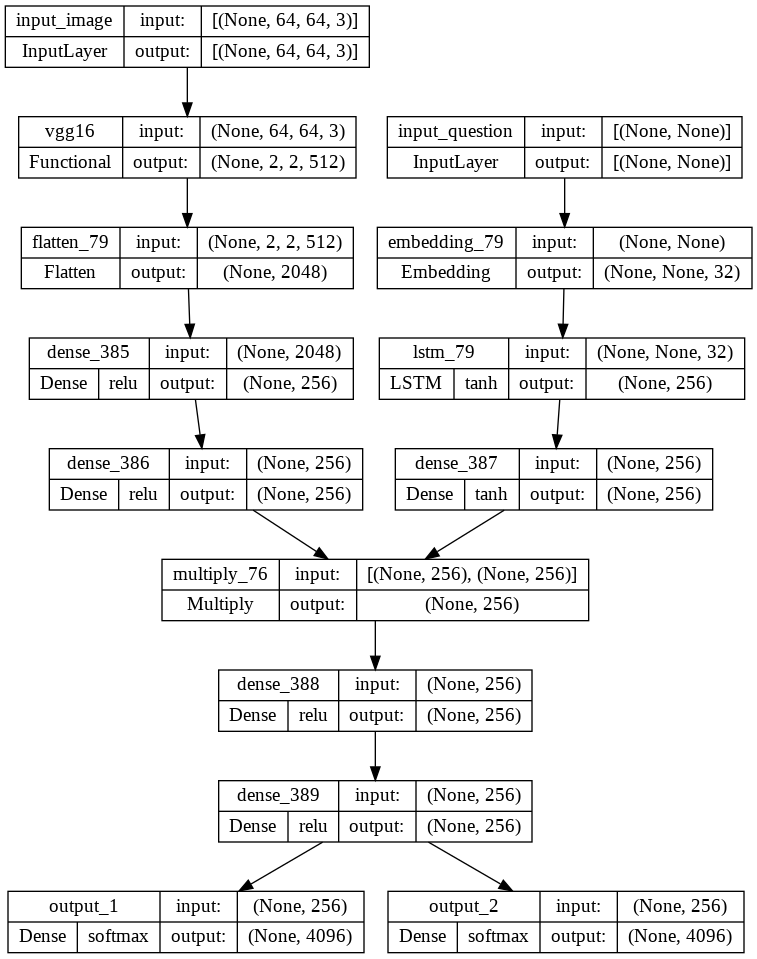

In [505]:
vocab_size = train_generator.question_dict.vocab_size

#Create VQA model
VQA_model = build_model(IMAGE_SIZE, vocab_size)
tf.keras.utils.plot_model(VQA_model,  show_shapes=True, show_layer_activations=True)

# Traning

In [506]:
def save_prediction(imgs, pred_bbes, gt_bbes, questions, ious,mode):
    total_rows = int(len(imgs)/3)+1
    row = 1
    plt.figure(figsize = (8*total_rows, 23))
    plt.suptitle(f"Plot some prediction on {mode.upper()} SET", fontsize = 26)
    for i in range(len(imgs)):
        plt.subplot(total_rows, 3, i+1)
        cv2.imwrite(f'./saved_images/img_{i}.jpg', imgs[i])
        img = cv2.cvtColor(cv2.imread(f'./saved_images/img_{i}.jpg'), cv2.COLOR_BGR2RGB)
        result = img.copy()
        cv2.rectangle(result, (int(pred_bbes[i][0]), int(pred_bbes[i][1])), (int(pred_bbes[i][2]), int(pred_bbes[i][3])), (255, 0, 0), 2)
        cv2.rectangle(result, (int(gt_bbes[i][0]), int(gt_bbes[i][1])), (int(gt_bbes[i][2]), int(gt_bbes[i][3])), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("\n".join(wrap(questions[i], 45)))

        plt.text(int(gt_bbes[i][0]), int(gt_bbes[i][1]) , "target", color = 'green', backgroundcolor = 'white')
        plt.text(int(pred_bbes[i][0]), int(pred_bbes[i][3]) , f"Prediction | IoU {round(ious[i],2)}", color = 'blue', backgroundcolor = 'white')
        plt.axis('off')
    plt.show()

class Log_Img_Callback(keras.callbacks.Callback):
    
    #SAVE PREDICTIONS ON WANDB
    def __init__(self, train_generator,val_generator):
        super().__init__()
        self.train_samples = train_generator[0]
        self.val_samples = val_generator[0]
        self.train_generator = train_generator
        
    def iou(self, box_predicted, box_truth):
        # get (x, y) coordinates of intersection of bounding boxes
        top_x_intersect = max(box_predicted[0], box_truth[0])
        top_y_intersect = max(box_predicted[1], box_truth[1])
        bottom_x_intersect = min(box_predicted[2], box_truth[2])
        bottom_y_intersect = min(box_predicted[3], box_truth[3])
        

        # calculate area of the intersection bb (bounding box)
        intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
            0, bottom_y_intersect - top_y_intersect + 1
        )

        # calculate area of the prediction bb and ground-truth bb
        box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
            box_predicted[3] - box_predicted[1] + 1
        )
        box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
            box_truth[3] - box_truth[1] + 1
        )

        # calculate intersection over union by taking intersection
        # area and dividing it by the sum of predicted bb and ground truth
        # bb areas subtracted by  the interesection area

        # return ioU
        return intersection_area / float(
            box_predicted_area + box_truth_area - intersection_area
        )
    
    def convert_bbox(self, left_top, right_bottom):
        left_top = np.argmax(left_top, 1)
        right_bottom = np.argmax(right_bottom, 1)
        bboxes = np.zeros((len(left_top), 4))
        bboxes[:, 0] = left_top//IMAGE_SIZE
        bboxes[:, 1] = left_top%IMAGE_SIZE
        bboxes[:, 2] = right_bottom//IMAGE_SIZE
        bboxes[:, 3] = right_bottom%IMAGE_SIZE
        return bboxes
        

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 or (epoch+1) == NUM_EPOCHS:
            train_input, train_outputs = self.train_samples
            train_predictions = self.model.predict(train_input, verbose = 0)
            train_outputs = self.convert_bbox(train_outputs['output_1'], train_outputs['output_2'])
            train_predictions = self.convert_bbox(train_predictions[0], train_predictions [1])
            imgs = train_input["input_image"]*225
            
            questions = []
            ious = []
            for i in range(len(train_predictions)):
                print()
                print(train_outputs[i])
                print(train_predictions[i])
                print("-"*150)
                iou = self.iou(train_predictions[i], train_outputs[i])
                text = ""
                for idx in train_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                questions.append(text)
                ious.append(iou)
            save_prediction(imgs, train_predictions, train_outputs, questions, ious, 'train')
            print("-"*150)
            print("-"*150)
            val_input, val_outputs = self.val_samples
            val_predictions = self.model.predict(val_input, verbose = 0)
            val_predictions =self.convert_bbox(val_predictions[0], val_predictions[1])
            val_outputs = self.convert_bbox(val_outputs['output_1'], val_outputs['output_2'])
            imgs = val_input["input_image"]*225
            questions = []
            ious = []
            for i in range(len(val_predictions)):
                iou = self.iou(val_predictions[i], val_outputs[i])
                text = ""
                for idx in val_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                questions.append(text)
                ious.append(iou)
            save_prediction(imgs, val_predictions, val_outputs, questions, ious, 'val')


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1000/1000 [==============================] - 103s 103ms/step - loss: 8.2801 - output_1_loss: 8.2851 - output_2_loss: 8.2752 - output_1_accuracy: 0.0045 - output_2_accuracy: 0.0050 - val_loss: 8.2591 - val_output_1_loss: 8.2456 - val_output_2_loss: 8.2725 - val_output_1_accuracy: 0.0070 - val_output_2_accuracy: 0.0030 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
1000/1000 [==============================] - 103s 103ms/step - loss: 7.7726 - output_1_loss: 7.7845 - output_2_loss: 7.7607 - output_1_accuracy: 0.0058 - output_2_accuracy: 0.0068 - val_loss: 8.4993 - val_output_1_loss: 8.4668 - val_output_2_loss: 8.5319 - val_output_1_accuracy: 0.0070 - val_output_2_accuracy: 0.0030 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
1000/1000 [==============================] - 103s 103ms/step - loss: 7.6296 - output_1_loss: 7.6410 - output_2_loss: 7.6182 - output_1_accuracy: 0.0058 - output_2_accuracy: 0

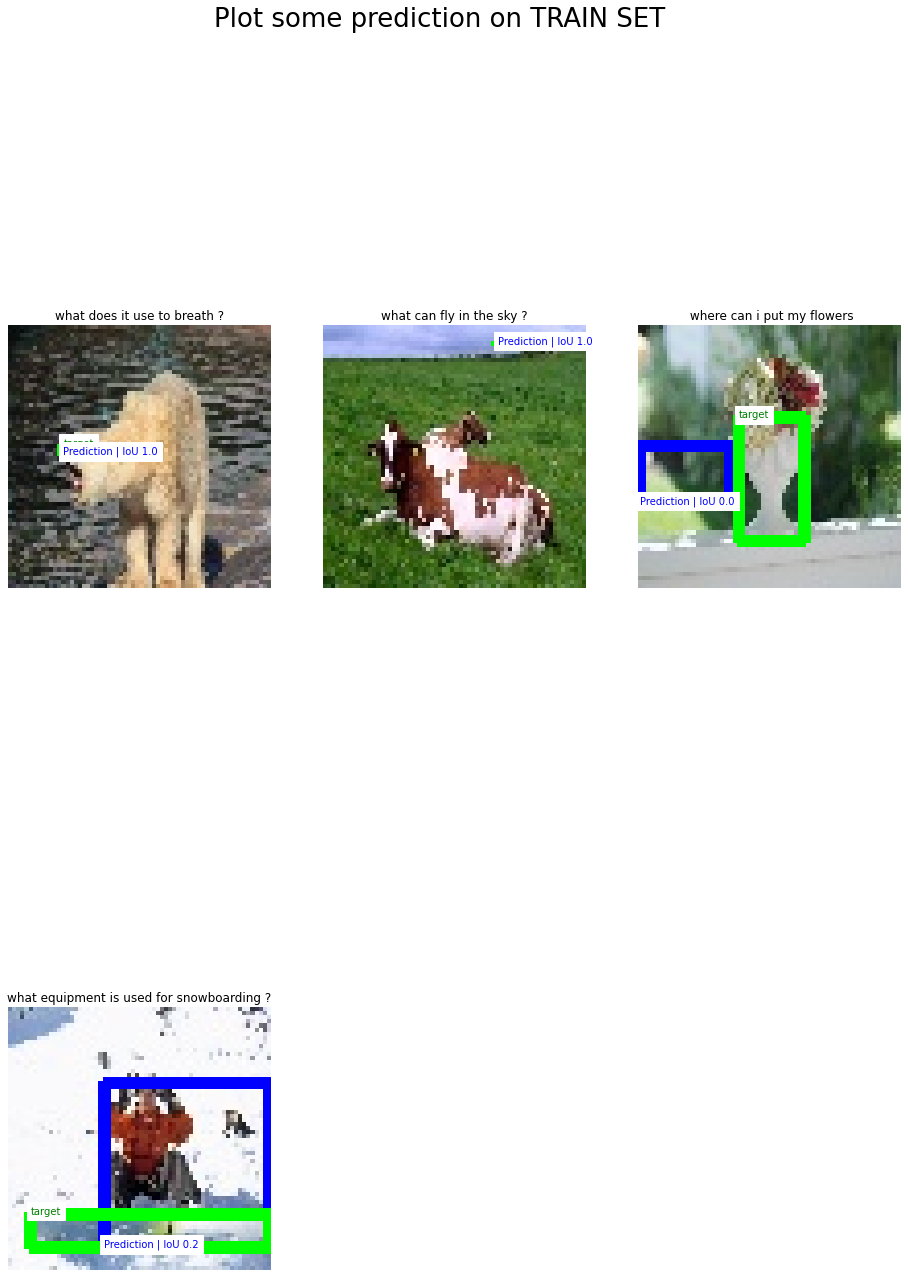

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------


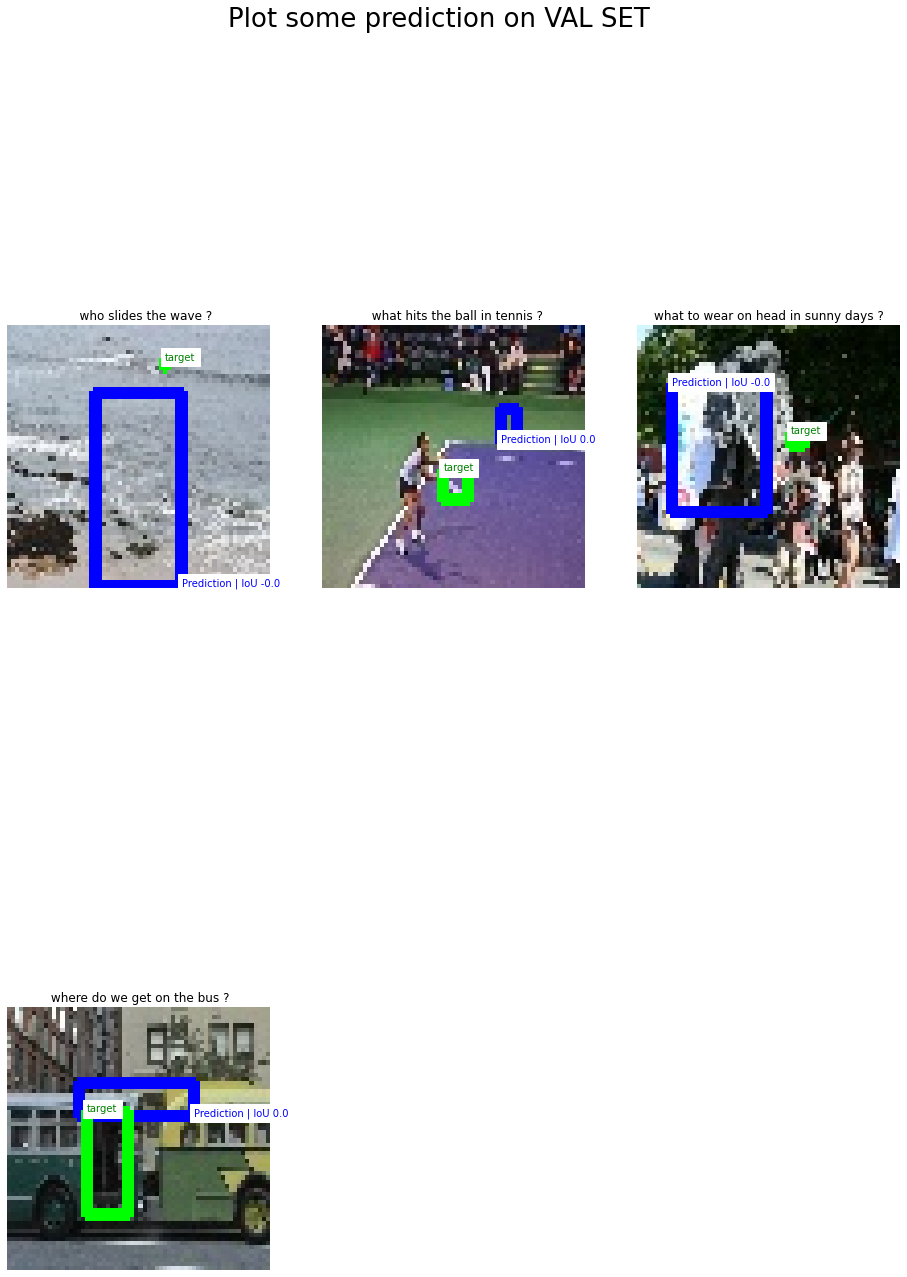

1000/1000 [==============================] - 104s 104ms/step - loss: 1.7410 - output_1_loss: 1.7234 - output_2_loss: 1.7586 - output_1_accuracy: 0.6233 - output_2_accuracy: 0.6143 - val_loss: 61.6375 - val_output_1_loss: 60.1192 - val_output_2_loss: 63.1557 - val_output_1_accuracy: 0.0010 - val_output_2_accuracy: 0.0000e+00 - lr: 1.0000e-06

Epoch 51: LearningRateScheduler setting learning rate to 1e-06.
Epoch 51/100
1000/1000 [==============================] - 102s 102ms/step - loss: 1.7374 - output_1_loss: 1.7204 - output_2_loss: 1.7545 - output_1_accuracy: 0.6235 - output_2_accuracy: 0.6162 - val_loss: 61.7247 - val_output_1_loss: 60.2007 - val_output_2_loss: 63.2487 - val_output_1_accuracy: 0.0010 - val_output_2_accuracy: 0.0000e+00 - lr: 1.0000e-06

Epoch 52: LearningRateScheduler setting learning rate to 1e-06.
Epoch 52/100
1000/1000 [==============================] - 104s 104ms/step - loss: 1.7340 - output_1_loss: 1.7167 - output_2_loss: 1.7513 - output_1_accuracy: 0.6250 - outp

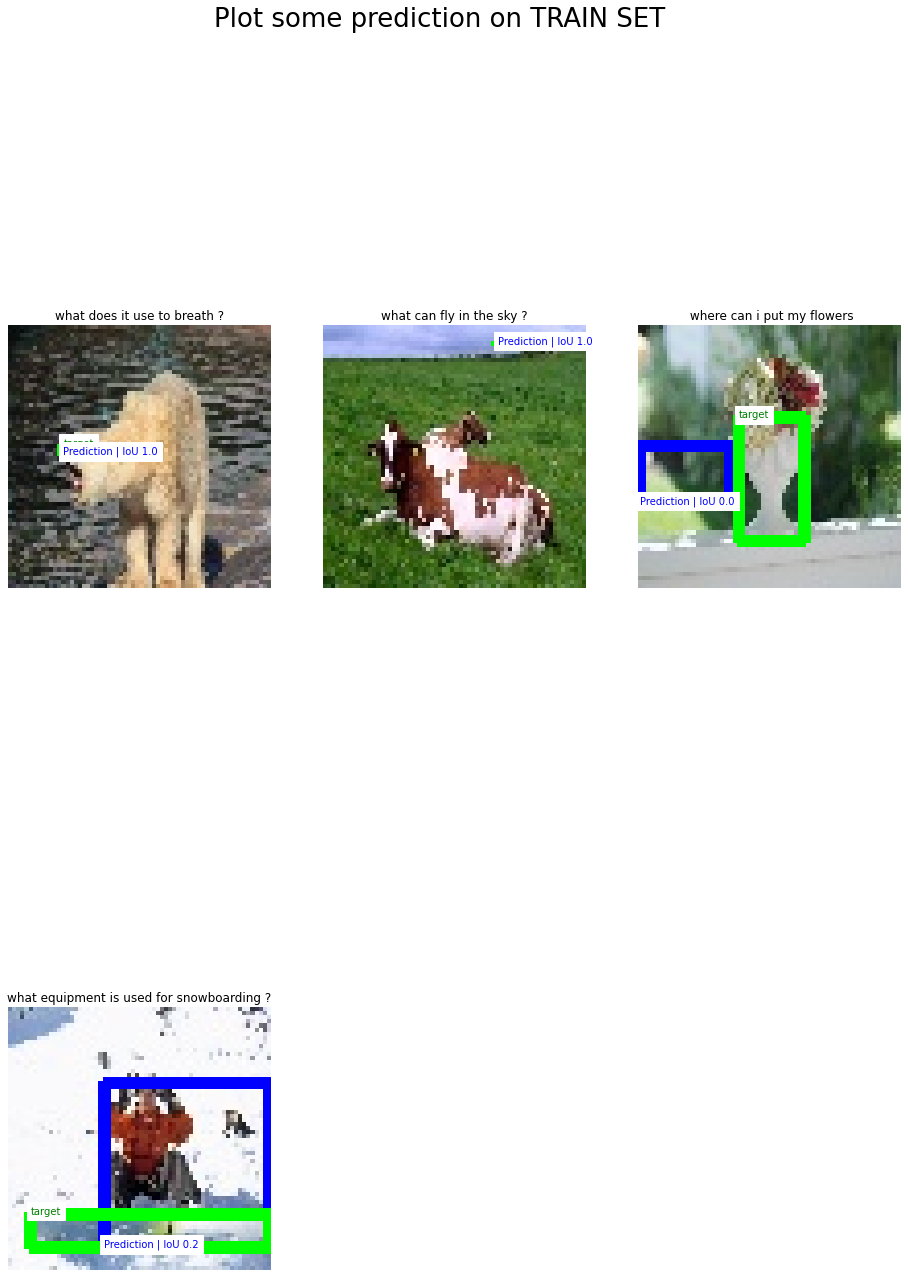

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------


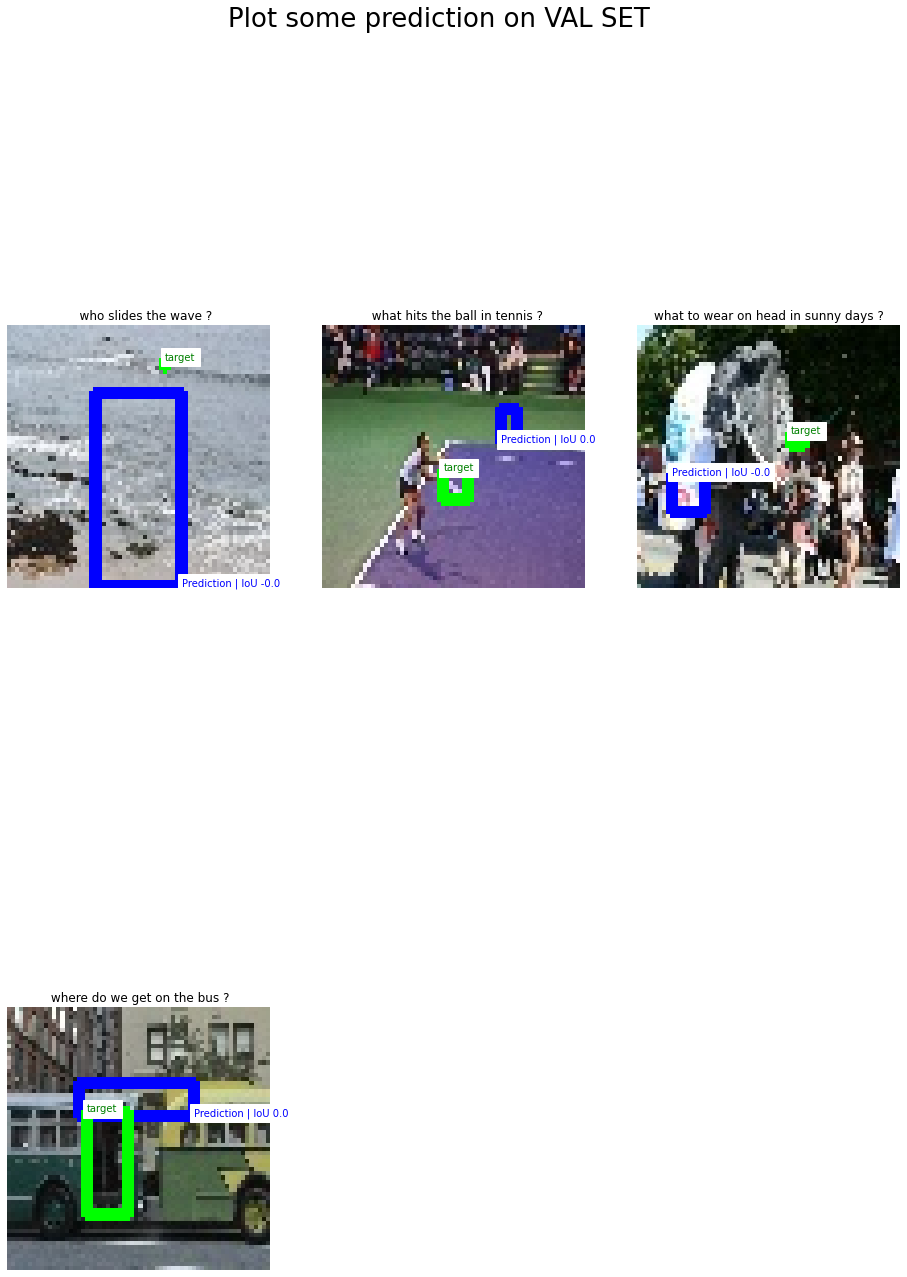

1000/1000 [==============================] - 104s 104ms/step - loss: 1.6250 - output_1_loss: 1.6085 - output_2_loss: 1.6415 - output_1_accuracy: 0.6505 - output_2_accuracy: 0.6373 - val_loss: 65.0946 - val_output_1_loss: 63.4757 - val_output_2_loss: 66.7134 - val_output_1_accuracy: 0.0010 - val_output_2_accuracy: 0.0010 - lr: 1.0000e-07


In [507]:
strategy = tf.distribute.OneDeviceStrategy(device=tf.config.list_physical_devices()[-1][1])
with strategy.scope():
    #Data Generation
    train_generator = DataGenerator(df_train,question_vocab, BATCH_SIZE)
    val_generator = DataGenerator(df_val,question_vocab, BATCH_SIZE)
    vocab_size = train_generator.question_dict.vocab_size

    #Create VQA model
    VQA_model = build_model(IMAGE_SIZE, vocab_size)

    #compile model
    losses={"output_1": "categorical_crossentropy", "output_2": "categorical_crossentropy"}
    loss_weights = {"output_1": 0.5, "output_2": 0.5}
    metrics={"output_1": ["accuracy"], "output_2": ["accuracy"]}
    VQA_model.compile(keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss=losses, metrics = metrics, loss_weights = loss_weights)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

    img_callback = Log_Img_Callback(train_generator, val_generator)
    callbacks = [lr_schedule, img_callback ]
        

    history = VQA_model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        callbacks = callbacks,
        verbose = 1,
        validation_data = val_generator,
    )

(<Figure size 2000x1000 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d7067fd0>,
       dtype=object))

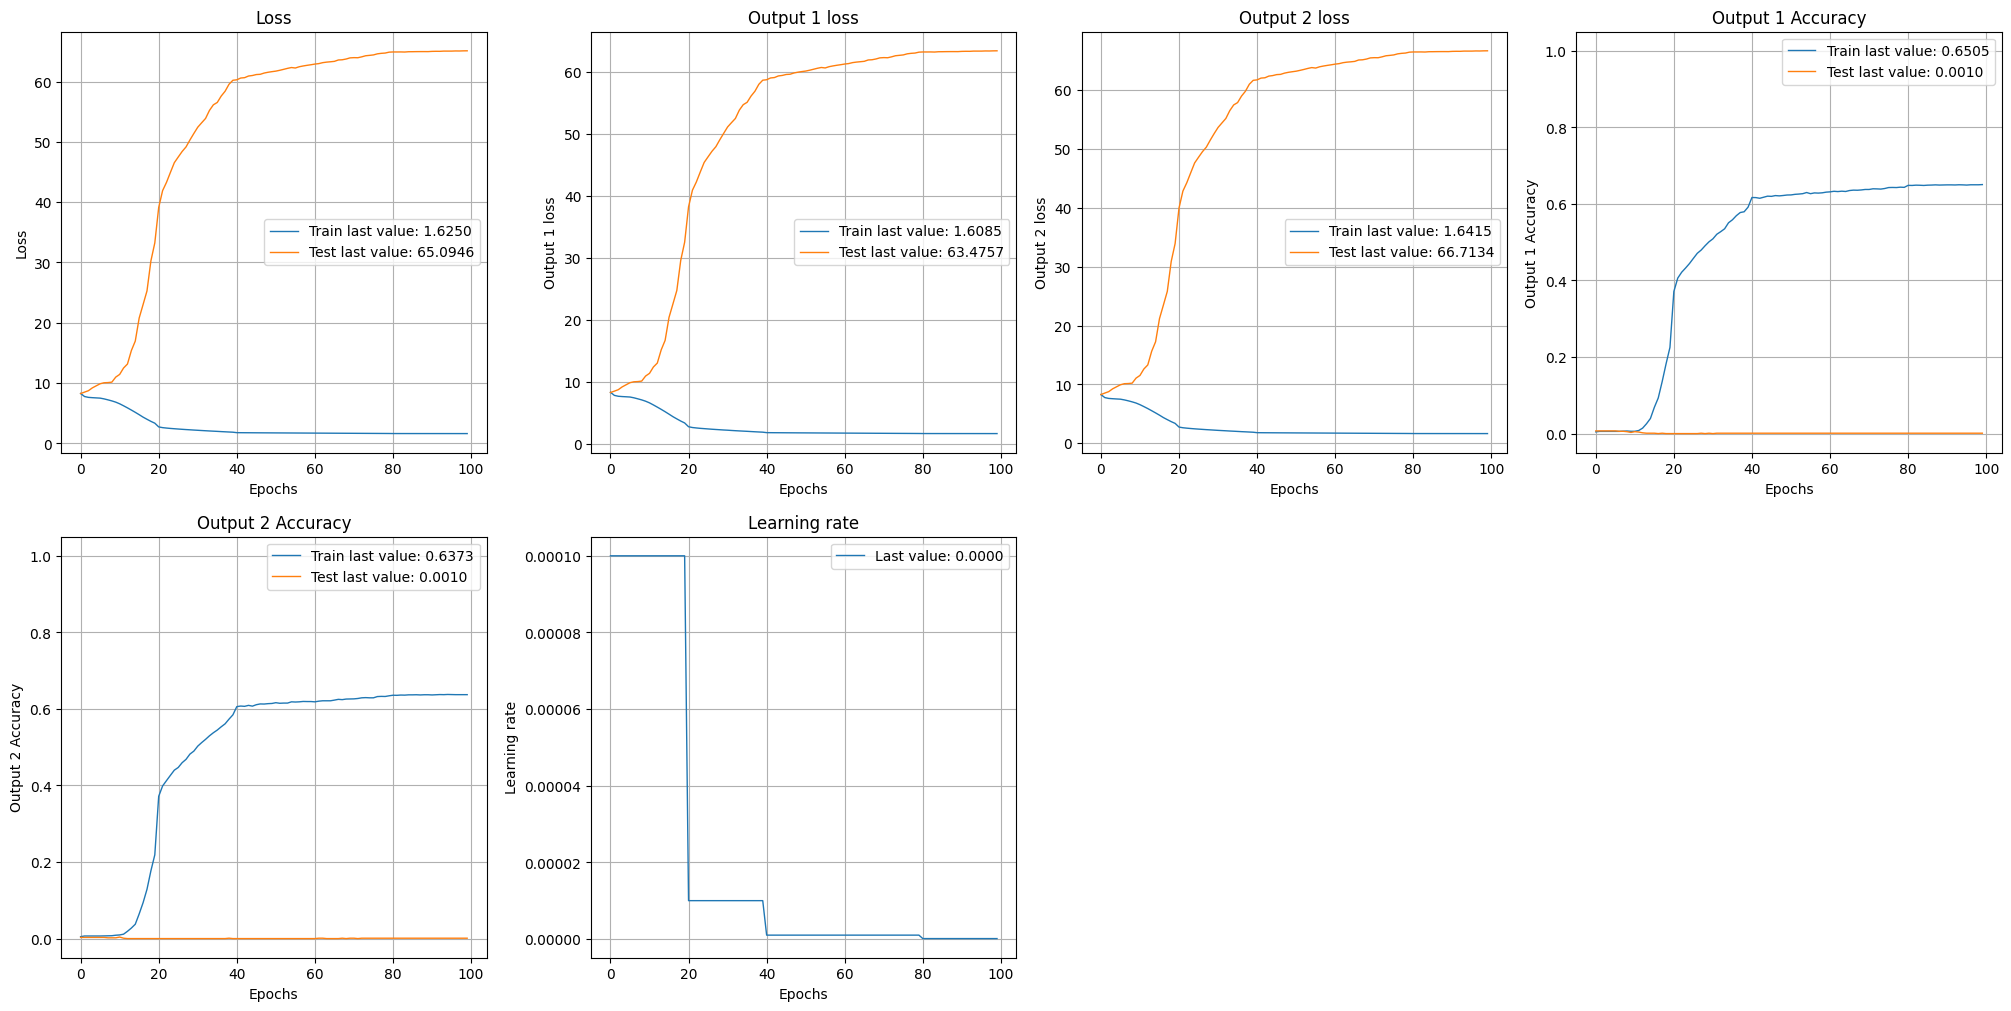

In [508]:
plot_history(history)